# Analysing cropped images
**Pipeline:**

1. Load prediction_results.csv per category
2. Slice into sub-dataframe:
    * lower-right corner contains _0
    * upper-right corner contains _1
    * raw image
    * lower-left corner contains _2
    * upper-left corner contains _3
3. Visualize statistical analytics:
    * Average prediction value per cropped corner vs. raw image result
    * Count number of mis-predicted/unidentified object
    * Relative ground-truth bbox size vs. raw image size
    * Relative predicted bbox size vs. cropped image size

In [1]:
# Import libraries
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import PIL
import os
%matplotlib inline

## Load prediction_results.csv per category

In [2]:
projectDir=os.getcwd()
dataDir='.'
dataType='val2017'
imageDir='{}/images/'.format(dataDir)

# Define image directory
annFile='{}/images/val2017_selected/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


In [232]:
cat = "book"
imageCatDir=os.path.join(imageDir, cat)
file_dir = imageCatDir + "/prediction_results.csv"
df_prediction_results = pd.read_csv(file_dir, header=0)

In [233]:
df_prediction_results.head()

,bbox,category,filename,height,path,width,pred,pred_cat,pred_bbox
0,"[271, 117, 36, 23]",book,1139919_0.jpg,140,./images/book/529148,307,NaN,NaN,NaN
1,"[271, 0, 36, 23]",book,1139919_1.jpg,309,./images/book/529148,307,NaN,NaN,NaN
2,"[0, 117, 36, 23]",book,1139919_2.jpg,140,./images/book/529148,369,NaN,NaN,NaN
3,"[0, 0, 36, 23]",book,1139919_3.jpg,309,./images/book/529148,369,NaN,NaN,NaN
4,"[270, 116, 35, 22]",book,1139919.jpg,426,./images/book/529148,640,NaN,NaN,NaN


In [234]:
if cat=="couch":
    df_prediction_results['pred_cat'] = df_prediction_results.pred_cat.str.replace('sofa', 'couch', regex=True)

## Relative ground truth bbox size in cropped images
relative_size = (bbox_w*bbox_h)/(width*height)*100%

In [235]:
def calculate_relative_bbox(bbox, img_size):
    bbox_x, bbox_y, bbox_w, bbox_h = map(int,bbox.strip('[]').split(', '))
    img_w, img_h = img_size
    return (bbox_w*bbox_h)/(img_w*img_h)*100
    
relative_size_true = []
for idx, item in df_prediction_results.iterrows():
    relative_size = calculate_relative_bbox(item.bbox, (item.width, item.height))
    relative_size_true.append(relative_size)
df_prediction_results['relative_size_true'] = relative_size_true

## Relative predicted bbox size in cropped images

In [236]:
def calculate_relative_bbox_predict(bbox_pred, img_size):
    if type(bbox_pred) is not str:
        return np.nan
    bbox_x, bbox_y, bbox_w, bbox_h = map(int,bbox_pred.strip('[]').split(', '))
    img_w, img_h = img_size
    return (bbox_w*bbox_h)/(img_w*img_h)*100

relative_size_pred = []
for idx, item in df_prediction_results.iterrows():
    relative_size = calculate_relative_bbox_predict(item.pred_bbox, (item.width, item.height))
    relative_size_pred.append(relative_size)
df_prediction_results['relative_size_pred'] = relative_size_pred

In [237]:
# create a list of our conditions
conditions = [
    (df_prediction_results.filename.str.contains("_0")),
    (df_prediction_results.filename.str.contains("_1")),
    (df_prediction_results.filename.str.contains("_2")),
    (df_prediction_results.filename.str.contains("_3")),
    (~df_prediction_results.filename.str.contains("_"))
    ]

# create a list of the values we want to assign for each condition
values = ['0', '1', '2', '3', '4']

# create a new column and use np.select to assign values to it using our lists as arguments
df_prediction_results['type'] = np.select(conditions, values)

In [238]:
df_prediction_results.groupby('type').agg(['mean','std'])

height               width                   pred             \
        mean         std    mean         std       mean        std   
type                                                                 
0     292.04  125.739503  338.10  176.314658  80.337306  14.991672   
1     265.35  132.534911  338.10  176.314658  80.051222  13.889987   
2     292.04  125.739503  338.81  192.968030  80.787571   9.457416   
3     265.35  132.534911  338.81  192.968030  75.730428  11.415840   
4     479.31   89.871591  586.34   84.305507  78.825126  13.471820   

     relative_size_true            relative_size_pred             
                   mean        std               mean        std  
type                                                              
0             13.324352  18.319288          16.313295  15.445344  
1             15.683722  21.416688          35.141417  30.372846  
2             10.661712  12.701625          14.956508  15.904623  
3             13.993236  18.598734          22.079398  28.552756  
4              3.452012   6.248199           5.812125   7.306601

In [239]:
df_0 = df_prediction_results[df_prediction_results.filename.str.contains("_0")]
df_1 = df_prediction_results[df_prediction_results.filename.str.contains("_1")]
df_2 = df_prediction_results[df_prediction_results.filename.str.contains("_2")]
df_3 = df_prediction_results[df_prediction_results.filename.str.contains("_3")]
df_raw = df_prediction_results[~df_prediction_results.filename.str.contains("_")]

## Average prediction value per cropped corner vs. raw image result
_Note_
- 0: lower-right corner @bottom
- 2: lower-left corner  @bottom
- 4: raw
- 1: upper-right corner
- 3: upper-left corner


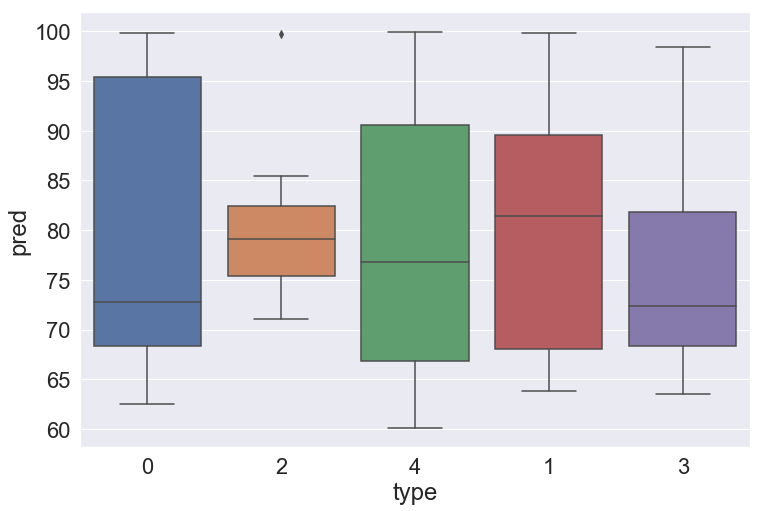

In [240]:
sns.boxplot(x='type', y='pred', data=df_prediction_results, order=['0','2','4','1','3'])

## Analysis

In [241]:
def qualified_item(_df):
    _df = _df[(_df.width/_df.height < 3) & (_df.width/_df.height > 0.3)]
    return _df
_df_0 = qualified_item(df_0)
_df_1 = qualified_item(df_1)
_df_2 = qualified_item(df_2)
_df_3 = qualified_item(df_3)
_df_raw = qualified_item(df_raw)
_df = pd.concat([_df_0, _df_1, _df_2, _df_3, _df_raw], axis=0)

In [242]:
_df.head()

,bbox,category,filename,height,path,width,pred,pred_cat,pred_bbox,relative_size_true,relative_size_pred,type
0,"[271, 117, 36, 23]",book,1139919_0.jpg,140,./images/book/529148,307,NaN,NaN,NaN,1.926477,NaN,0
5,"[239, 241, 55, 24]",book,1139063_0.jpg,265,./images/book/344621,294,72.755408,book,"[240, 240, 50, 21]",1.694263,1.347709,0
10,"[334, 96, 37, 54]",book,1985721_0.jpg,150,./images/book/112798,371,NaN,NaN,NaN,3.590296,NaN,0
15,"[319, 165, 31, 42]",book,1139451_0.jpg,207,./images/book/385719,350,NaN,NaN,NaN,1.797101,NaN,0
20,"[339, 349, 183, 198]",book,1652379_0.jpg,547,./images/book/389315,522,97.542787,book,"[332, 358, 183, 183]",12.689907,11.728551,0


In [243]:
print(_df_0.shape[0])
print(_df_2.shape[0])
print(_df_raw.shape[0])
print(_df_1.shape[0])
print(_df_3.shape[0])

82
76
100
72
75


## Count number of mis-predicted/unidentified object

In [244]:
_df.groupby('type').agg(['mean','std'])

height                   width                   pred             \
            mean         std        mean         std       mean        std   
type                                                                         
0     309.621951  115.125336  340.987805  160.654025  80.337306  14.991672   
1     293.236111  122.402533  322.430556  146.516146  78.354986  14.399634   
2     307.105263  107.199077  358.736842  177.112045  80.787571   9.457416   
3     279.306667  115.088447  361.093333  173.304308  76.515357  11.818642   
4     479.310000   89.871591  586.340000   84.305507  78.825126  13.471820   

     relative_size_true            relative_size_pred             
                   mean        std               mean        std  
type                                                              
0             12.396035  18.116794          16.313295  15.445344  
1             15.172293  21.405444          27.139900  23.858075  
2             11.119872  14.102488          14.956508  15.904623  
3             12.891206  18.854265          13.968001  13.303246  
4              3.452012   6.248199           5.812125   7.306601

In [245]:
# Count number of unidentified object
print(_df_0.pred_cat.isnull().sum())
print(_df_2.pred_cat.isnull().sum())
print(_df_raw.pred_cat.isnull().sum())
print(_df_1.pred_cat.isnull().sum())
print(_df_3.pred_cat.isnull().sum())

71
69
79
66
66


In [246]:
# Count number of misclassified object
print(_df_0.shape[0] - _df_0[_df_0.pred_cat == _df_0.category].shape[0]-_df_0.pred_cat.isnull().sum())
print(_df_2.shape[0] - _df_2[_df_2.pred_cat == _df_2.category].shape[0]-_df_2.pred_cat.isnull().sum())
print(_df_raw.shape[0] - _df_raw[_df_raw.pred_cat == _df_raw.category].shape[0]-_df_raw.pred_cat.isnull().sum())
print(_df_1.shape[0] - _df_1[_df_1.pred_cat == _df_1.category].shape[0]-_df_1.pred_cat.isnull().sum())
print(_df_3.shape[0] - _df_3[_df_3.pred_cat == _df_3.category].shape[0]-_df_3.pred_cat.isnull().sum())

0
2
2
1
0


### Prediction confidence comparison

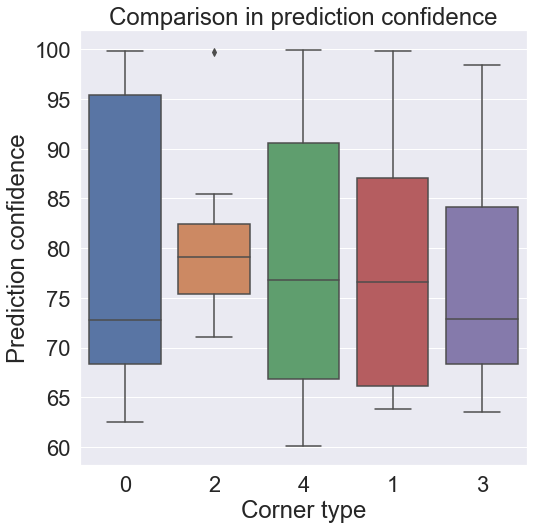

In [247]:
plt.rcParams['figure.figsize']=(8,8)
sns.boxplot(x='type', y='pred', data=_df, order=['0','2','4','1','3'])
sns.set(font_scale=2)
plt.title("Comparison in prediction confidence")
plt.ylabel("Prediction confidence")
plt.xlabel("Corner type")
plt.show()

### Ground truth vs. prediction bounding box size

In [248]:
_df.head()

,bbox,category,filename,height,path,width,pred,pred_cat,pred_bbox,relative_size_true,relative_size_pred,type
0,"[271, 117, 36, 23]",book,1139919_0.jpg,140,./images/book/529148,307,NaN,NaN,NaN,1.926477,NaN,0
5,"[239, 241, 55, 24]",book,1139063_0.jpg,265,./images/book/344621,294,72.755408,book,"[240, 240, 50, 21]",1.694263,1.347709,0
10,"[334, 96, 37, 54]",book,1985721_0.jpg,150,./images/book/112798,371,NaN,NaN,NaN,3.590296,NaN,0
15,"[319, 165, 31, 42]",book,1139451_0.jpg,207,./images/book/385719,350,NaN,NaN,NaN,1.797101,NaN,0
20,"[339, 349, 183, 198]",book,1652379_0.jpg,547,./images/book/389315,522,97.542787,book,"[332, 358, 183, 183]",12.689907,11.728551,0


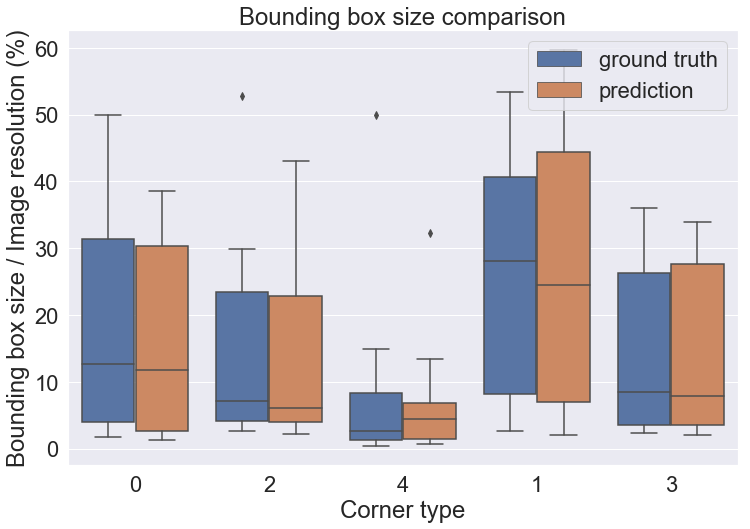

In [249]:
_df1 = _df.dropna()
# _df1 = _df.copy()

_df_groundtruth = pd.DataFrame()
_df_groundtruth['relative_size'] = _df1['relative_size_true']
_df_groundtruth['type'] = _df1['type']
_df_groundtruth['class'] = 'ground truth'

_df_prediction = pd.DataFrame()
_df_prediction['relative_size'] = _df1['relative_size_pred']
_df_prediction['type'] = _df1['type']
_df_prediction['class'] = 'prediction'

_df_analysis1 = pd.concat([_df_groundtruth, _df_prediction], axis=0, ignore_index=True)

plt.rcParams['figure.figsize']=(12,8)
sns.boxplot(x='type', y='relative_size', data=_df_analysis1, order=['0','2','4','1','3'], hue='class')
plt.legend(loc='upper right')
plt.xlabel('Corner type')
plt.ylabel('Bounding box size / Image resolution (%)')
plt.title('Bounding box size comparison')
plt.show()

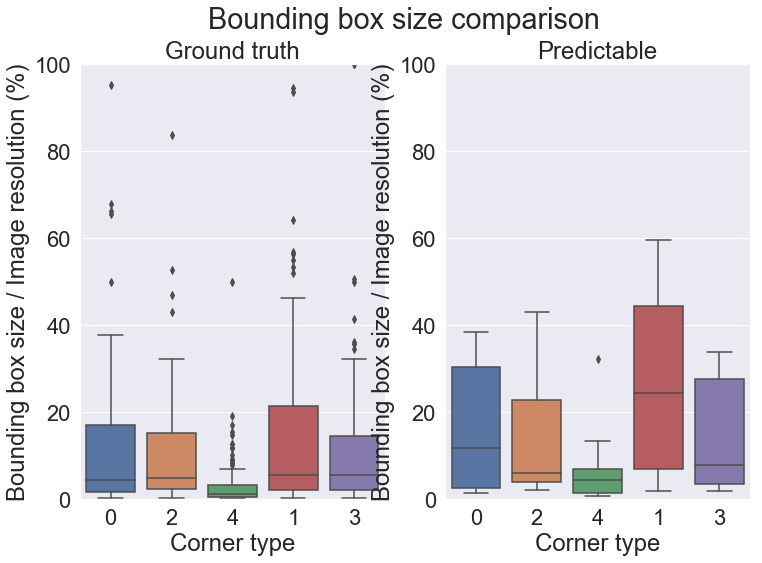

In [250]:
fig, axs = plt.subplots(1, 2)
plt.rcParams['figure.figsize']=(20,8)
plt.subplots_adjust(hspace = 1.8)
sns.boxplot(x='type', y='relative_size_true', data=_df, order=['0','2','4','1','3'], ax=axs[0])
sns.boxplot(x='type', y='relative_size_pred', data=_df, order=['0','2','4','1','3'], ax=axs[1])
sns.set(font_scale = 2)
axs[0].set_title('Ground truth')
axs[1].set_title('Predictable')
axs[0].set_ylim(0, 100); axs[1].set_ylim(0, 100)
axs[0].set_ylabel('Bounding box size / Image resolution (%)')
axs[1].set_ylabel('Bounding box size / Image resolution (%)')
axs[0].set_xlabel('Corner type')
axs[1].set_xlabel('Corner type')
fig.suptitle('Bounding box size comparison')
plt.show()

### Classified vs. Misclassified objects

In [251]:
df_misclassified = _df[_df.pred_cat!=_df.category]
df_classified = _df[_df.pred_cat==_df.category]

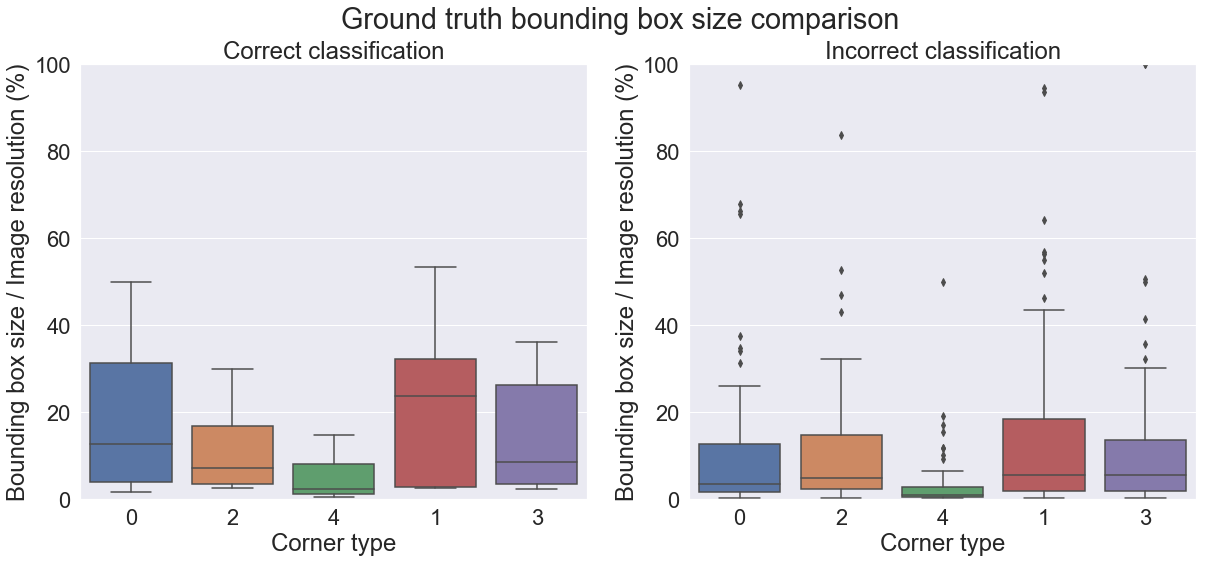

In [252]:
fig, axs = plt.subplots(1, 2)
plt.rcParams['figure.figsize']=(20,8)
plt.subplots_adjust(hspace = 1.8)
sns.boxplot(x='type', y='relative_size_true', data=df_classified, order=['0','2','4','1','3'], ax=axs[0])
sns.boxplot(x='type', y='relative_size_true', data=df_misclassified, order=['0','2','4','1','3'], ax=axs[1])
sns.set(font_scale = 2)
axs[0].set_title('Correct classification')
axs[1].set_title('Incorrect classification')
axs[0].set_ylim(0, 100); axs[1].set_ylim(0, 100)
axs[0].set_ylabel('Bounding box size / Image resolution (%)')
axs[1].set_ylabel('Bounding box size / Image resolution (%)')
axs[0].set_xlabel('Corner type')
axs[1].set_xlabel('Corner type')
fig.suptitle('Ground truth bounding box size comparison')
plt.show()

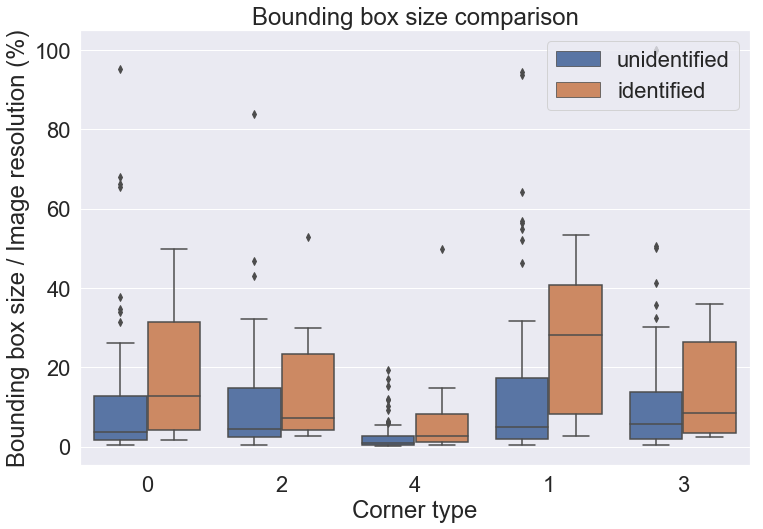

In [253]:
is_NaN = _df. isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = _df[row_has_NaN]
rows_with_value = _df[~row_has_NaN]

_df_NaN = pd.DataFrame()
_df_NaN['relative_size'] = rows_with_value['relative_size_true']
_df_NaN['type'] = rows_with_value['type']
_df_NaN['class'] = 'identified'

_df_value = pd.DataFrame()
_df_value['relative_size'] = rows_with_NaN['relative_size_true']
_df_value['type'] = rows_with_NaN['type']
_df_value['class'] = 'unidentified'

_df_analysis2 = pd.concat([_df_value, _df_NaN], axis=0, ignore_index=True)

plt.rcParams['figure.figsize']=(12,8)
sns.boxplot(x='type', y='relative_size', data=_df_analysis2, order=['0','2','4','1','3'], hue='class')
plt.legend(loc='upper right')
plt.xlabel('Corner type')
plt.ylabel('Bounding box size / Image resolution (%)')
plt.title('Bounding box size comparison')
plt.show()